In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
from PIL import Image
import random

drive.mount('/content/drive')
npzip = np.load('/content/drive/My Drive/point_cloud_mnist.npz')

Mounted at /content/drive


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Fri Oct 30 12:37:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self):
        self.data = (torch.from_numpy(npzip['X']).float() - 48.) / 48.
        self.targets = torch.from_numpy(npzip['Y']).long()

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


mb_size = 64
dataset = DataSet()
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=mb_size, shuffle=True, drop_last=True)

In [4]:
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)



class PointNetVanllia(nn.Module):

    def __init__(self):
        super(PointNetVanllia, self).__init__()
        self.H = nn.Sequential(
            nn.Conv1d(2, 64, 1), #(B, 2, N) -> (B, 64, N)
            nn.ReLU(),
            nn.Conv1d(64, 64, 1), #(B, 64, N) -> (B, 64, N)
            nn.ReLU(),
            nn.Conv1d(64, 128, 1), #(B, 64, N) -> (B, 128, N),
            nn.ReLU(),
            nn.Conv1d(128, 512, 1), #(B, 128, N) -> (B, 512, N)
        ).to(device)

        self.G = nn.Sequential(
            nn.AdaptiveMaxPool1d((1)), #(B, 512, N) -> (B, 512, 1)
            View((-1, 512)) #(B, 512, N) -> (B, 512)
        ).to(device)

        self.classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        ).to(device)

    def forward(self, x):
        x = x.transpose(1, 2) #(B, N, 2) -> (B, 2, N)
        h = self.H(x) #(B, 2, N) -> (B, 512, N)
        g = self.G(h) #(B, 512, N) -> (B, 10)
        return self.classifier(g)


model = PointNetVanllia()
solver = optim.Adam(model.parameters(), lr=1e-5)

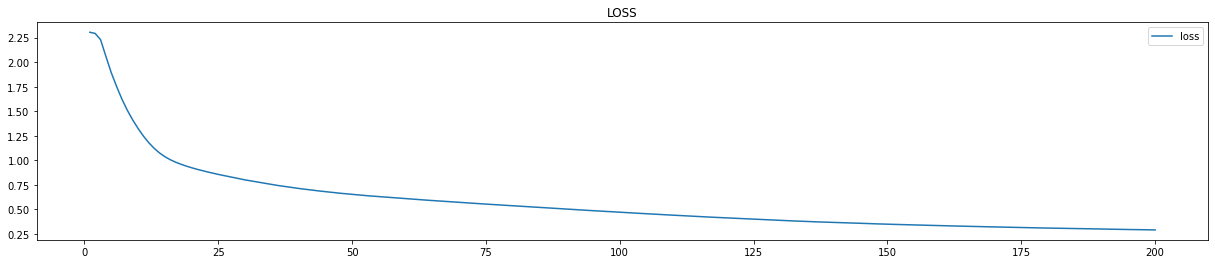

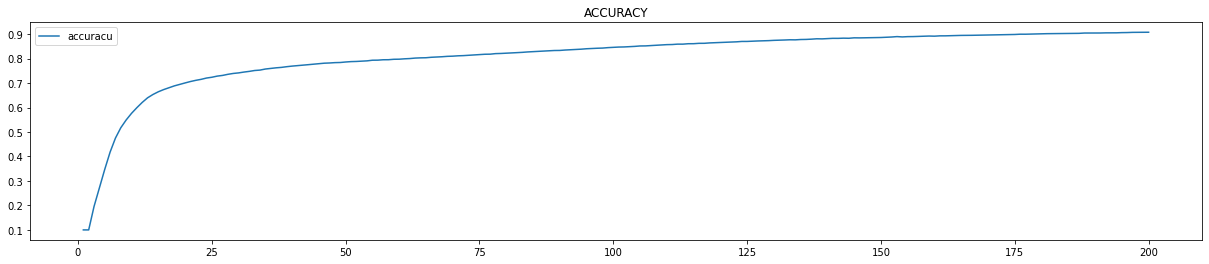

In [5]:
LOSS = []
ACCURACY = []
num_epochs = 200
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0
    for _, (X, Y) in enumerate(loader):
        X = X.to(device)
        Y = Y.to(device)
        solver.zero_grad()
        logit = model(X)
        loss = F.cross_entropy(logit, Y, reduction='mean')
        loss.backward()
        solver.step()
        epoch_loss += loss.item()
        batch_accuracy = (torch.argmax(logit.detach(), dim=-1) == Y).sum().item() / mb_size
        epoch_accuracy += batch_accuracy
    LOSS.append(epoch_loss / len(loader))
    ACCURACY.append(epoch_accuracy / len(loader))


plt.figure(figsize=(21, 4))
plt.title('LOSS')
plt.plot(np.arange(1, len(LOSS) + 1), LOSS, label='loss')
plt.legend()
plt.show()

plt.figure(figsize=(21, 4))
plt.title('ACCURACY')
plt.plot(np.arange(1, len(ACCURACY) + 1), ACCURACY, label='accuracu')
plt.legend()
plt.show() 

In [6]:
print('final loss:', LOSS[-1])
print('final accuracy:', ACCURACY[-1])

final loss: 0.29134702622858666
final accuracy: 0.9080342849519744


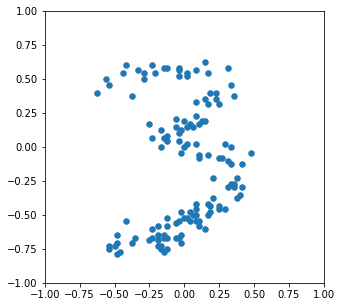

0 :  0.000
1 :  0.000
2 :  0.000
3 :  0.994
4 :  0.000
5 :  0.003
6 :  0.000
7 :  0.001
8 :  0.002
9 :  0.000


In [8]:
test_index = 10000
plt.figure(figsize=(5, 5))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter(dataset.data[test_index, :, 0], dataset.data[test_index, :, 1], s=30)
plt.show()
test_data = dataset.data[test_index].unsqueeze(0).to(device)
logit = model(test_data)
np.set_printoptions(precision=3, suppress=True)
pred = F.softmax(logit[0], dim=-1).cpu().detach().numpy()
for i in range(10):
    print(i,': ', format(pred[i], '.3f'))